<a href="https://colab.research.google.com/github/cosmin-pandeleanu/CV/blob/main/FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
myDataFolder = ('/content/drive/MyDrive/Licenta/Data/')

Mounted at /content/drive


# Dataset

In [2]:
""" IMPORT ALL DEPENDENCIES"""
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline
# import color maps
from matplotlib.colors import ListedColormap

# Seaborn for easier visualization
import seaborn as sns

In [3]:
# Citim datele din .csv
df = pd.read_csv(myDataFolder + "fer2013/fer2013.csv")
print("df.shape = ", df.shape)

df.shape =  (35887, 3)


In [4]:
print(df)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

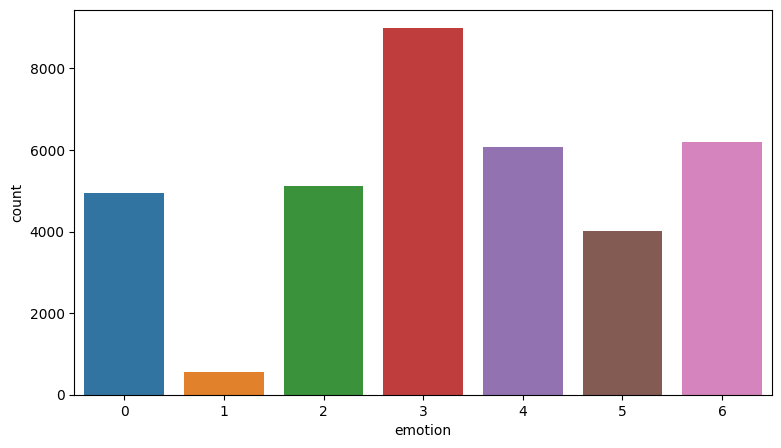

In [5]:
# Plotting emotion #
""" matplotlib => to define size , sns => to use counterplot """

plt.figure(figsize=(9, 5))
sns.countplot(x='emotion', data=df)
df['emotion'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

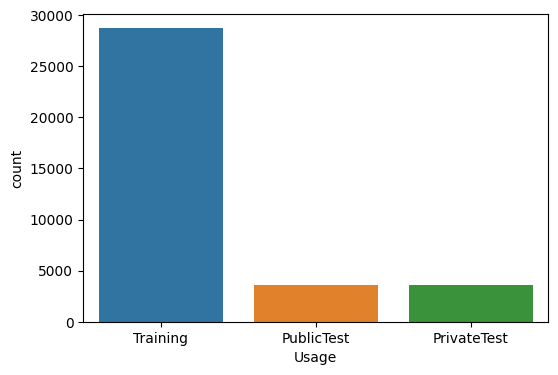

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Usage', data=df)
df['Usage'].value_counts()

# PreProcessing

In [7]:
import cv2
image_size = (48,48)
pixels = df['pixels'].tolist() # Converting the relevant column element into a list for each row
width, height = 48, 48
faces = []

for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')] # Splitting the string by space character as a list
  face = np.asarray(face).reshape(width, height) #converting the list to numpy array in size of 48*48
  face = cv2.resize(face.astype('uint8'),image_size) #resize the image to have 48 cols (width) and 48 rows (height)
  faces.append(face.astype('float32')) #makes the list of each images of 48*48 and their pixels in numpyarray form
  
faces = np.asarray(faces) #converting the list into numpy array
faces = np.expand_dims(faces, -1) #Expand the shape of an array -1=last dimension => means color space
emotions = pd.get_dummies(df['emotion']).to_numpy() #doing the one hot encoding type on emotions

In [8]:
# print(faces[0]) #Pixels after preprocessing

In [9]:
print(faces.shape)
print(faces[0].ndim)
print(type(faces))

(35887, 48, 48, 1)
3
<class 'numpy.ndarray'>


In [10]:
print(emotions[0]) #Emotion after preprocessing

[1 0 0 0 0 0 0]


In [11]:
print(emotions.shape)
print(emotions.ndim)
print(type(emotions))

(35887, 7)
2
<class 'numpy.ndarray'>


# Splitting the dataset

In [12]:
x = faces.astype('float32')
x = x / 255.0 #Dividing the pixels by 255 for normalization  => range(0,1)

# Scaling the pixels value in range(-1,1)
x = x - 0.5
x = x * 2.0

In [13]:
# print(x[0])

In [14]:
type(x)

numpy.ndarray

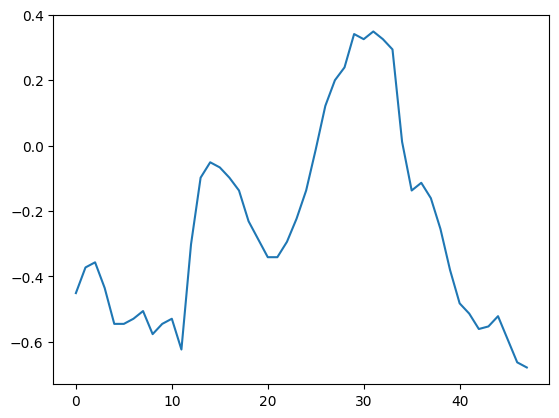

In [15]:
plt.plot(x[0,0])
plt.show()

In [16]:
print(x.min(),x.max()) # we can observe that pixels are scale

-1.0 1.0


# Splitting the dataset into train & validation set

In [17]:
num_samples, num_classes = emotions.shape

num_samples = len(x)
num_train_samples = int((1 - 0.2)*num_samples)

# Traning data
train_x = x[:num_train_samples]
train_y = emotions[:num_train_samples]

# Validation data
val_x = x[num_train_samples:]
val_y = emotions[num_train_samples:]

train_data = (train_x, train_y)
val_data = (val_x, val_y)

print('Training Pixels:', train_x.shape)  # ==> 4 dims -  no of images , width , height , color
print('Training labels:', train_y.shape)
print('Validation Pixels:', val_x.shape)
print('Validation labels:', val_y.shape)

Training Pixels: (28709, 48, 48, 1)
Training labels: (28709, 7)
Validation Pixels: (7178, 48, 48, 1)
Validation labels: (7178, 7)


# Defining Model

In [18]:
#load the libaray to built the model
from keras import layers
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D, Flatten, Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras.models import Sequential, Model
from keras.regularizers import l2

In [19]:
input_shape=(48, 48, 1)
num_classes = 7

In [20]:
""" Building up Model Architecture """

model = Sequential()
model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same', name='image_array', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same'))



model.add(BatchNormalization())
model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3), padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Activation('softmax', name='predictions'))

### chatAI
# model = Sequential()
# model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(7, activation='softmax'))
###

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_array (Conv2D)        (None, 48, 48, 16)        800       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        12560     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 16)       64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 48, 48, 16)        0         
                                                                 
 average_pooling2d (AverageP  (None, 24, 24, 16)       0

In [21]:
# parameters
batch_size = 32 #Number of samples per gradient update
num_epochs = 200 # Number of epochs to train the model.
#input_shape = (64, 64, 1)
verbose = 1 #per epochs  progress bar
num_classes = 7 
patience = 50

In [22]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping,  ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [23]:
""" Data Augmentation => taking the batch and apply some series of random transformations (random rotation, resizing, shearing) 
      ===> to increase generalizability of model  """

# data generator Generate batches of tensor image data with real-time data augmentation
data_generator = ImageDataGenerator(
                        featurewise_center = False,
                        featurewise_std_normalization = False,
                        rotation_range = 10,
                        width_shift_range = 0.1,
                        height_shift_range = 0.1,
                        zoom_range = .1,
                        horizontal_flip = True)

In [24]:
# model parameters/compilation

""" CONFIGURATION ==>.compile(optimizer, loss , metrics) """
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_array (Conv2D)        (None, 48, 48, 16)        800       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        12560     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 16)       64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 48, 48, 16)        0         
                                                                 
 average_pooling2d (AverageP  (None, 24, 24, 16)       0

# Training

In [25]:
datasets = ['fer2013']
num_epochs = 100
base_path = myDataFolder + "result/"
for dataset_name in datasets:
    print('Training dataset:', dataset_name)
    #callbacks
    log_file_path = dataset_name + '_emotion_training.log'

    csv_logger = CSVLogger(log_file_path, append=False)
    early_stop = EarlyStopping('val_loss', patience=patience)
    reduce_lr = ReduceLROnPlateau('val_loss', 
                                  factor = 0.1,
                                  patience = int(patience/4), 
                                  verbose = 1)
    
    trained_models_path = base_path + dataset_name + 'simple_cnn'
    model_names = trained_models_path + '.{epoch:03d}-{val_loss:.2f}.hdf5'      
    # if error "acc" in 1 line ... don't confuse check entire block since fit() generates a inner loop
    model_checkpoint = ModelCheckpoint(model_names, 
                                       'val_loss', 
                                       verbose = 1,
                                       save_best_only = True)
    my_callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

    # loading dataset
    train_faces, train_emotions = train_data
    history = model.fit(data_generator.flow(train_faces, train_emotions, batch_size),
                        epochs = num_epochs, 
                        verbose = 1, 
                        callbacks = my_callbacks, 
                        validation_data = val_data)  
     #not callbacks = [my_callbacks] since we my_callbacks is already a list 

Training dataset: fer2013
Epoch 1/100
896/898 [============================>.] - ETA: 0s - loss: 1.7854 - accuracy: 0.2802
Epoch 1: val_loss improved from inf to 1.87110, saving model to /content/drive/MyDrive/Licenta/Data/result/fer2013simple_cnn.001-1.87.hdf5
898/898 [==============================] - 45s 27ms/step - loss: 1.7850 - accuracy: 0.2803 - val_loss: 1.8711 - val_accuracy: 0.2831 - lr: 0.0010
Epoch 2/100
896/898 [============================>.] - ETA: 0s - loss: 1.6620 - accuracy: 0.3442
Epoch 2: val_loss improved from 1.87110 to 1.56901, saving model to /content/drive/MyDrive/Licenta/Data/result/fer2013simple_cnn.002-1.57.hdf5
898/898 [==============================] - 22s 25ms/step - loss: 1.6621 - accuracy: 0.3443 - val_loss: 1.5690 - val_accuracy: 0.3915 - lr: 0.0010
Epoch 3/100
897/898 [============================>.] - ETA: 0s - loss: 1.5972 - accuracy: 0.3695
Epoch 3: val_loss improved from 1.56901 to 1.49892, saving model to /content/drive/MyDrive/Licenta/Data/resul

In [26]:
#evaluate() returns [loss,acc]
score = model.evaluate(val_x, val_y, verbose = 1) 
print('Test loss: ', score[0])
print('Test accuracy: ', score[1]*100)


225/225 [==============================] - 2s 7ms/step - loss: 1.0599 - accuracy: 0.5926
Test loss:  1.0599421262741089
Test accuracy:  59.264421463012695


# History

In [27]:
""" metrics collected by history object """
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [28]:
print(history_dict["accuracy"])

[0.28026053309440613, 0.34428226947784424, 0.36943119764328003, 0.3924205005168915, 0.4138423502445221, 0.4261033236980438, 0.4397227466106415, 0.45264551043510437, 0.46218955516815186, 0.4647671580314636, 0.47566965222358704, 0.4753910005092621, 0.48378556966781616, 0.4861193299293518, 0.49183183908462524, 0.4934689402580261, 0.49350377917289734, 0.4989027976989746, 0.49991291761398315, 0.5015848875045776, 0.507192850112915, 0.5039534568786621, 0.5094918012619019, 0.5116513967514038, 0.5118255615234375, 0.5121042132377625, 0.513392984867096, 0.5080636739730835, 0.5146469473838806, 0.5155526399612427, 0.5166324377059937, 0.5201504826545715, 0.5218572616577148, 0.5196627974510193, 0.5226932168006897, 0.523598849773407, 0.5208819508552551, 0.5239471793174744, 0.525862991809845, 0.5265944600105286, 0.5270472764968872, 0.5274304151535034, 0.5306698083877563, 0.529346227645874, 0.531122624874115, 0.5259326100349426, 0.5295552015304565, 0.5299383401870728, 0.5286146998405457, 0.5294855237007

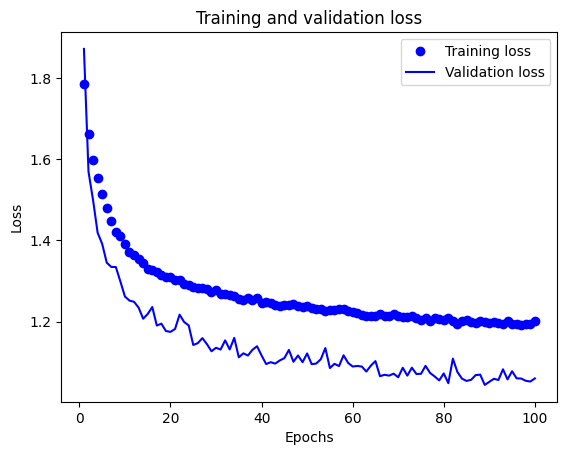

In [29]:
""" Visualising model training history """
import matplotlib.pyplot as plt

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, train_loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

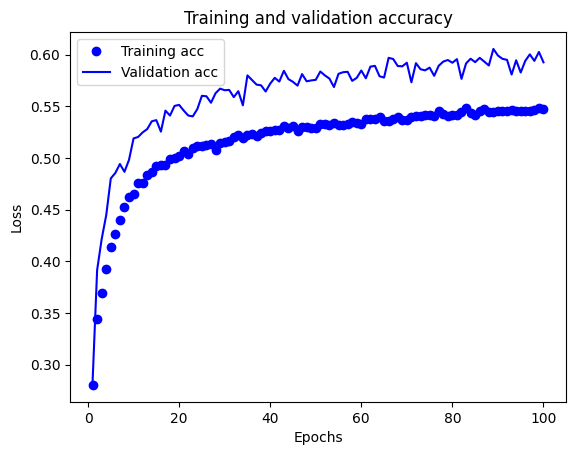

In [30]:
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing

In [31]:
emotion_dict = {0: "Neutral", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Sad", 5: "Surprised", 6: "Neutral"}

#emojis unicodes # 
emojis = { 0:"\U0001f620",1:"\U0001f922" ,2:"\U0001f628" ,3:"\U0001f60A" , 4:"\U0001f625" ,5:"\U0001f632",6:"\U0001f610" }

In [32]:
print(emojis.values(),sep=" ")

dict_values(['😠', '🤢', '😨', '😊', '😥', '😲', '😐'])


In [33]:
from google.colab.patches import cv2_imshow
import cv2

def _predict(path):
  facecasc = cv2.CascadeClassifier( myDataFolder + 'haarcascade_frontalface_default.xml')
  imagePath = myDataFolder + path
  image = cv2.imread(imagePath)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=10)
  print("No of faces : ",len(faces))
  i = 1
  for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 6)
    roi_gray = gray[y:y + h, x:x + w]                      #croping
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
    prediction = model.predict(cropped_img)

    maxindex = int(np.argmax(prediction))
    print("person ",i," : ",emotion_dict[maxindex], "-->",emojis[maxindex])
    cv2.putText(image, emotion_dict[maxindex], (x + 10, y - 20), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255, 255, 255),
                        2)
                                              
  #if text is not apeared , change coordinates. it may work
  
  cv2_imshow(image)

In [ ]:
# _predict("images/img.jpg")
# _predict("images/img2.jpg")
# _predict("images/img3.jpg")
# _predict("images/img4.jpg")
# _predict("images/img5.jpg")
# _predict("images/ntr.jpg")
# _predict("images/mb.jpg")
# _predict("images/Ram_Charan.webp")
# _predict("images/khans.jpg")
# _predict("images/radu1.jpg")
# _predict("images/radu2.jpg")
# _predict("images/radu3.jpg")
# _predict("images/radu4.jpg")
# _predict("images/radu5.jpg")

# Saving Model

In [ ]:
# model.save_weights(myDataFolder + "model/model.h5")
# model.load_weights(myDataFolder + "model/model.h5")

In [36]:
from keras.models import model_from_json

def save_model():
  model_json = model.to_json()
  with open(myDataFolder + "model/model1.json", "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(myDataFolder + "model/model1.h5")
  print("Saved model to disk")
 
# # later...
 
# # load json and create model
# json_file = open(myDataFolder + "model/model.json", 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# # load weights into new model
# model.load_weights(myDataFolder + "model/model.h5")
save_model()

Saved model to disk


In [ ]:
""" loading the model in modular approach """

def load_model_():
  json_file = open(myDataFolder + "model/model.json", 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  # load weights into new model
  model.load_weights(myDataFolder + "model/model.h5")
  return model

model = load_model_()

Processing image: images/test/test_1.jpg
No of faces :  1
1/1 [==============================] - 0s 19ms/step
person  1  :  Disgusted --> 🤢


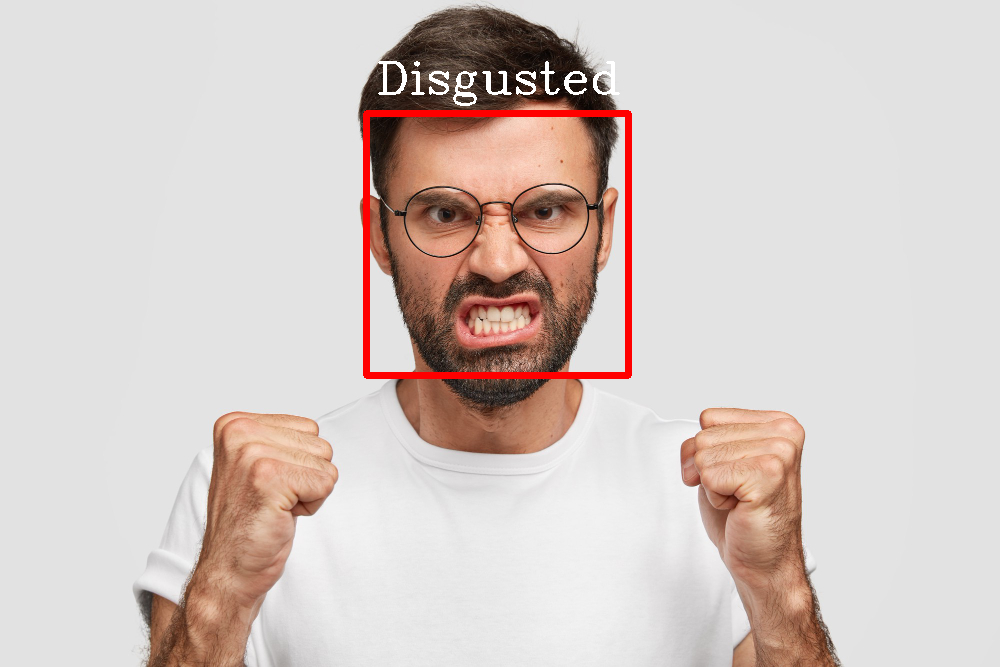

Processing image: images/test/test_2.jpg
No of faces :  1
1/1 [==============================] - 0s 19ms/step
person  1  :  Neutral --> 😠


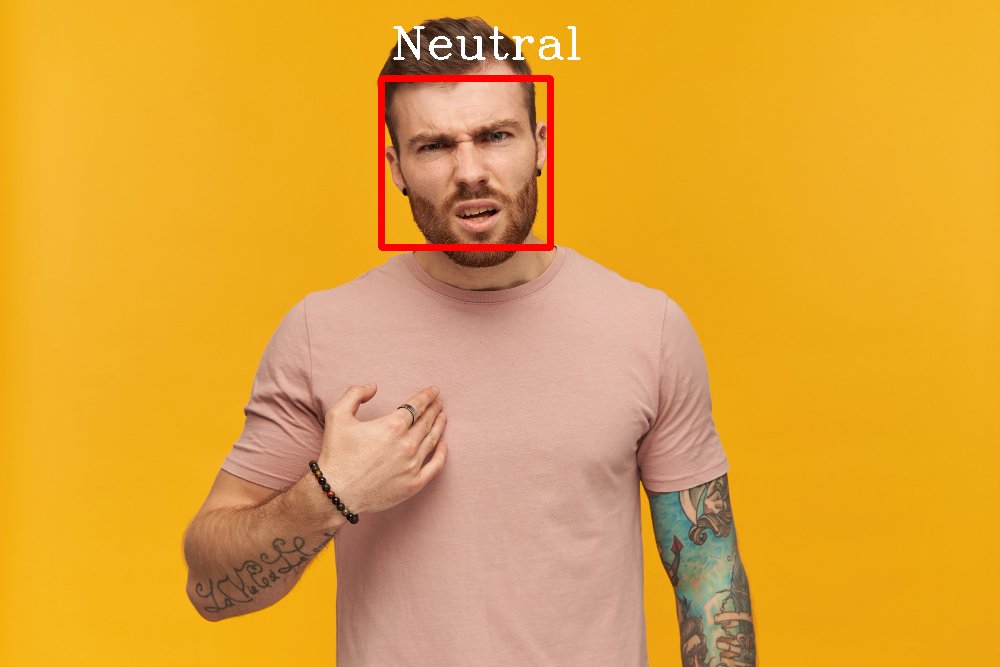

Processing image: images/test/test_3.jpg
No of faces :  1
1/1 [==============================] - 0s 31ms/step
person  1  :  Fearful --> 😨


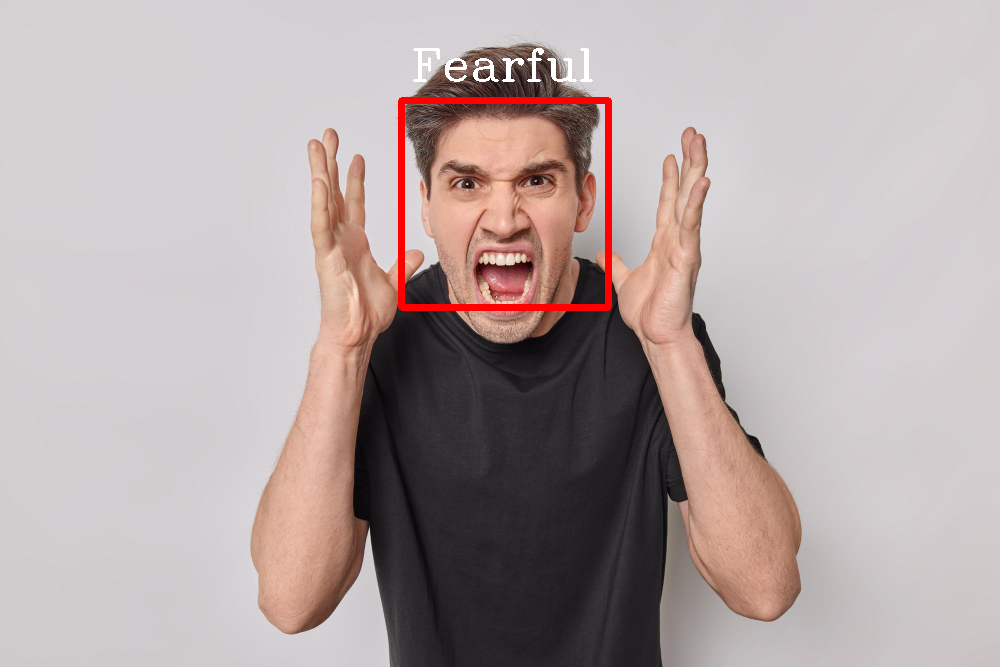

Processing image: images/test/test_4.jpg
No of faces :  1
1/1 [==============================] - 0s 48ms/step
person  1  :  Fearful --> 😨


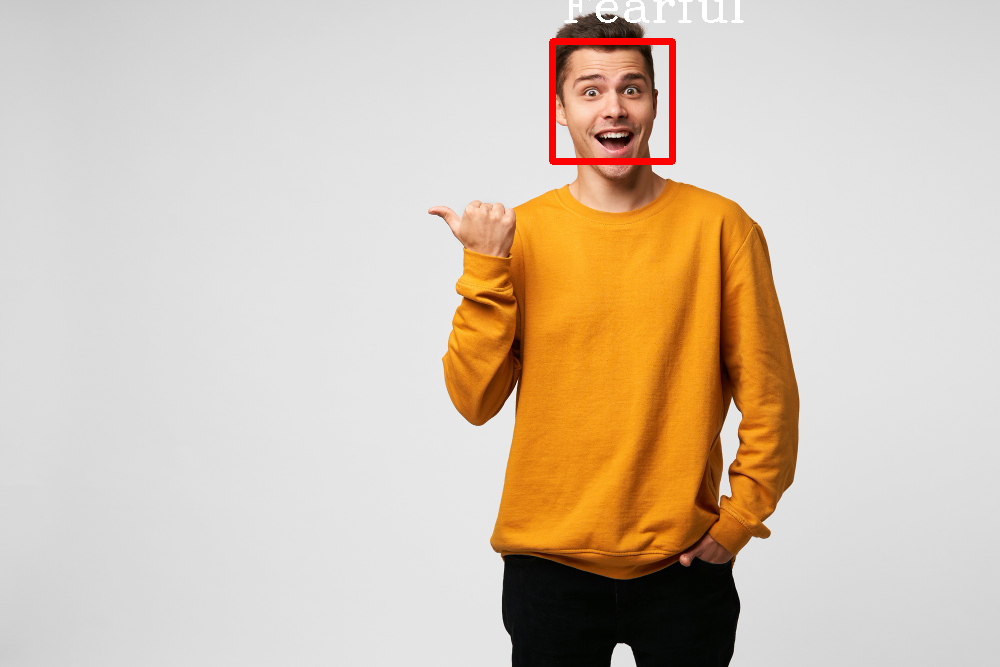

Processing image: images/test/test_5.jpg
No of faces :  1
1/1 [==============================] - 0s 29ms/step
person  1  :  Fearful --> 😨


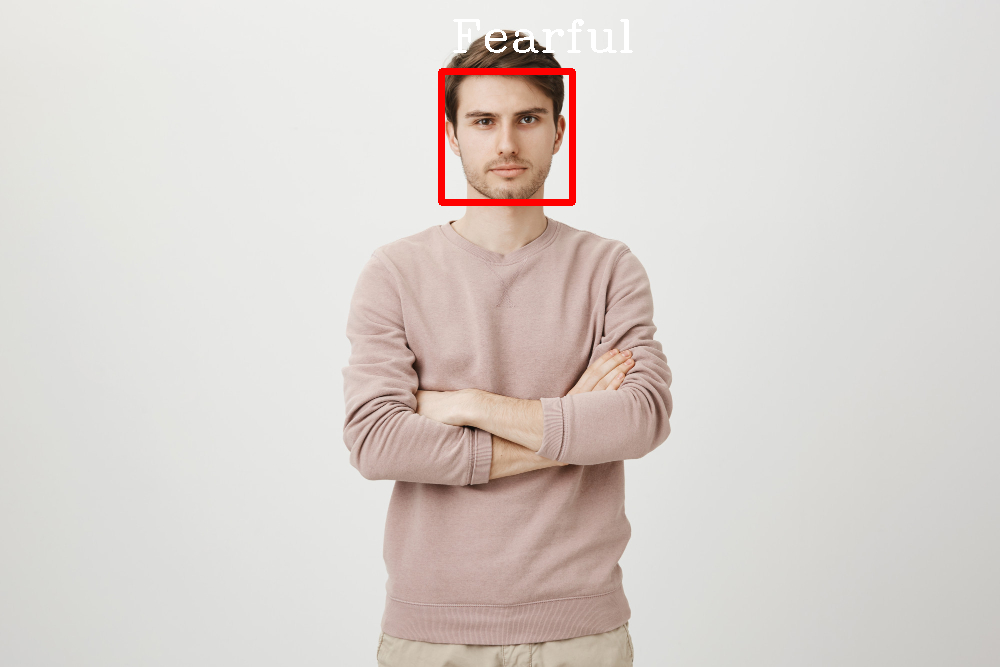

Processing image: images/test/test_6.jpg
No of faces :  1
1/1 [==============================] - 0s 33ms/step
person  1  :  Fearful --> 😨


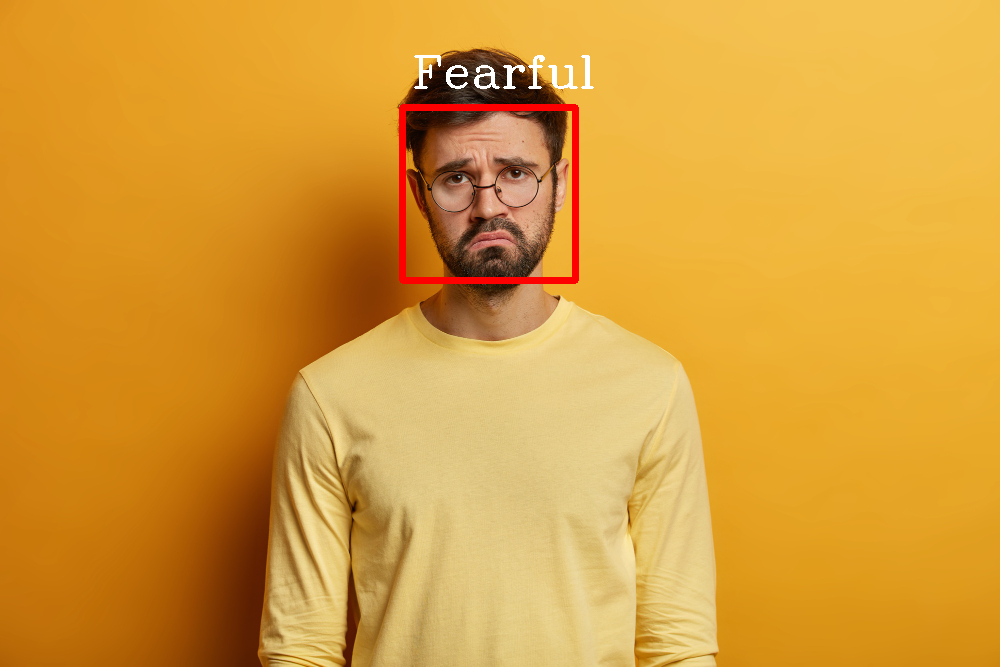

Processing image: images/test/test_7.jpg
No of faces :  1
1/1 [==============================] - 0s 30ms/step
person  1  :  Surprised --> 😲


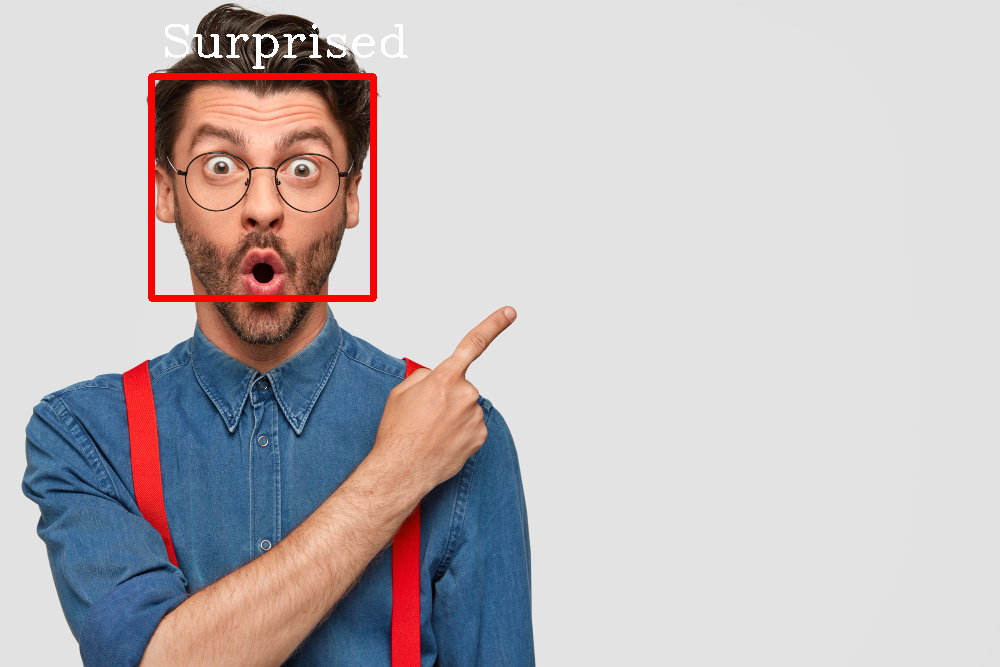

In [44]:
# Teste
# import os
# image_dir = myDataFolder + '/images/'
# for filename in os.listdir(image_dir):
#     if filename.endswith(".jpg") or filename.endswith(".png"):
#         image_path = os.path.join(image_dir, filename)
        
#         _predict(image_path)
#         print("Processed image:", filename)

# _predict("images/test/test_1.jpg")
# _predict("images/test/test_2.jpg")
# _predict("images/test/test_3.jpg")
# _predict("images/test/test_4.jpg")



for i in range(1, 8):
  image_path = f"images/test/test_{i}.jpg"
  print(f"Processing image: {image_path}")
  _predict(image_path)